In [55]:
# Imports

from scipy import stats 
import numpy as np
import math
from math import e
from math import factorial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dados = pd.read_excel('carros.xlsx')

In [56]:
dados.head(1)

,title,price_in_aed,kilometers,body_condition,mechanical_condition,seller_type,body_type,no_of_cylinders,transmission_type,regional_specs,horsepower,fuel_type,steering_side,year,color,emirate,motors_trim,company,model,date_posted
0,MITSUBISHI PAJERO 3.5L / 2013,"26,000",167390,Perfect inside and out,Perfect inside and out,Dealer,SUV,6,Automatic Transmission,GCC Specs,Unknown,Gasoline,Left Hand Side,2013.0,Silver,Dubai,GLS,mitsubishi,pajero,13/05/2022


----
### Filtragem de Colunas

In [57]:
# REMOVENDO COLUNAS QUE FORAM JULGADAS DESNECESSARIAS
dados.drop(["seller_type", "no_of_cylinders", "regional_specs", "steering_side", "color", "emirate","motors_trim","model"], axis=1, inplace=True)
dados.head(1)

,title,price_in_aed,kilometers,body_condition,mechanical_condition,body_type,transmission_type,horsepower,fuel_type,year,company,date_posted
0,MITSUBISHI PAJERO 3.5L / 2013,"26,000",167390,Perfect inside and out,Perfect inside and out,SUV,Automatic Transmission,Unknown,Gasoline,2013.0,mitsubishi,13/05/2022


----
### Filtro de Marcas

In [58]:
# FILTRANDO AS MARCAS QUE SERAM UTILIZADAS
marcas = ['nissan', 'audi', 'mercedes-benz', 'lamborghini', 'maserati', 'bmw', 'bentley','ferrari']
dados = dados.loc[dados.company.isin(marcas),:]
dados.head(3)

# dados.to_excel(r"C:\Users\alber\OneDrive\Desktop\2022.2\Cdados\Projeto2\dfNovo.xlsx", index = False)

,title,price_in_aed,kilometers,body_condition,mechanical_condition,body_type,transmission_type,horsepower,fuel_type,year,company,date_posted
2,MERCEDES-BENZ E300 - 2014 - GCC SPEC - FULL OP...,"78,000",200000,Perfect inside and out,Perfect inside and out,Sedan,Automatic Transmission,400 - 500 HP,Gasoline,2014.0,mercedes-benz,05/05/2022
3,WARRANTY UNTIL APR 2023 || Ferrari 488 Spider ...,"899,000",27000,Perfect inside and out,Perfect inside and out,Hard Top Convertible,Automatic Transmission,600 - 700 HP,Gasoline,2018.0,ferrari,30/04/2022
5,A7 S-line Quattro. Under Warranty. Accidents F...,"98,000",84000,Perfect inside and out,Perfect inside and out,Sedan,Automatic Transmission,200 - 300 HP,Gasoline,2015.0,audi,30/04/2022


Após a filtragem de marcas e colunas, iremos utilizar a planilha de dados com um total de 12 colunas e 3956 linhas, que inicialmente possuía 20 colunas e 9970 linhas.
As colunas são: 
* Title
* Price in aed
* Kilometers
* Body Condition
* Mechanical Condition 
* Body Type
* Transmission Type
* Horsepower
* Fuel Type

E as marcas:
* Nissan
* Audi
* Mercedes
* Lamborghini
* Maserati
* Bmw
* Bentley
* Ferrari

In [59]:
preco = dados['price_in_aed'].apply(lambda x: float(x.replace(".","").replace(",","")))

In [60]:
dados['price_in_aed'] = preco

## Vendo as correlações

----
### Preço x Marca

<AxesSubplot:xlabel='company', ylabel='price_in_aed'>

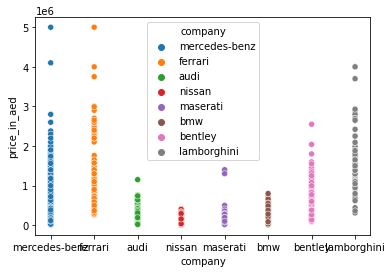

In [61]:
sns.scatterplot(data=dados, x="company", y=preco, hue= dados['company'])

In [62]:
# preco.to_frame()
pd.crosstab(preco, dados['company'])

company,audi,bentley,bmw,ferrari,lamborghini,maserati,mercedes-benz,nissan
price_in_aed,,,,,,,,
6000.0,0,0,0,0,0,0,0,1
9900.0,0,0,0,0,0,0,0,1
11300.0,0,0,0,0,0,0,0,1
11500.0,0,0,0,0,0,0,0,2
11900.0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
3750000.0,0,0,0,1,0,0,0,0
3999000.0,0,0,0,1,0,0,0,0
4000000.0,0,0,0,0,2,0,0,0


In [63]:
#anoQuilometragem = dados.kilometers.corr(dados.year)

precoQuilometragem = preco.corr(dados.kilometers)
print(precoQuilometragem)


-0.3997980667660921


In [64]:
dados.groupby(dados['company'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
company,,,,,,,,
audi,381.0,1.846744e+05,194791.915491,14900.0,57000.0,100000.0,239000.0,1149000.0
bentley,144.0,5.329396e+05,413301.718775,85000.0,259000.0,397000.0,701500.0,2549000.0
bmw,690.0,1.567887e+05,136079.232967,15000.0,62000.0,113500.0,199375.0,799000.0
ferrari,135.0,1.248726e+06,862446.400306,265000.0,627000.0,999000.0,1577500.0,4999000.0
lamborghini,108.0,1.591880e+06,679751.879203,309000.0,1279000.0,1489000.0,1798250.0,4000000.0
maserati,94.0,2.179308e+05,224392.652842,15000.0,112725.0,172250.0,248750.0,1400000.0
mercedes-benz,1506.0,3.693308e+05,438582.966341,11900.0,95000.0,199900.0,444750.0,4999000.0
nissan,898.0,9.553123e+04,79150.493072,6000.0,39500.0,69000.0,125000.0,409000.0


In [66]:
pd.crosstab(dados['price_in_aed'], dados['company'])

company,audi,bentley,bmw,ferrari,lamborghini,maserati,mercedes-benz,nissan
price_in_aed,,,,,,,,
6000.0,0,0,0,0,0,0,0,1
9900.0,0,0,0,0,0,0,0,1
11300.0,0,0,0,0,0,0,0,1
11500.0,0,0,0,0,0,0,0,2
11900.0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
3750000.0,0,0,0,1,0,0,0,0
3999000.0,0,0,0,1,0,0,0,0
4000000.0,0,0,0,0,2,0,0,0


----
### Preço x Condição

In [67]:
pd.crosstab(dados['price_in_aed'], dados['body_condition'])

body_condition,"A bit of wear & tear, all repaired","No accidents, very few faults","Normal wear & tear, a few issues",Perfect inside and out
price_in_aed,,,,
6000.0,1,0,0,0
9900.0,0,0,0,1
11300.0,0,0,0,1
11500.0,1,0,0,1
11900.0,0,0,0,1
...,...,...,...,...
3750000.0,0,0,0,1
3999000.0,0,0,0,1
4000000.0,0,0,0,2


----
### Preço x Tipo

In [68]:
pd.crosstab(dados['price_in_aed'], dados['body_type'])

body_type,Coupe,Crossover,Hard Top Convertible,Hatchback,Other,Pick Up Truck,SUV,Sedan,Soft Top Convertible,Sports Car,Utility Truck,Van,Wagon
price_in_aed,,,,,,,,,,,,,
6000.0,0,0,0,0,0,0,0,1,0,0,0,0,0
9900.0,0,0,0,0,0,0,0,1,0,0,0,0,0
11300.0,0,0,0,0,0,0,0,1,0,0,0,0,0
11500.0,0,0,0,0,0,0,2,0,0,0,0,0,0
11900.0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750000.0,0,0,1,0,0,0,0,0,0,0,0,0,0
3999000.0,1,0,0,0,0,0,0,0,0,0,0,0,0
4000000.0,1,0,0,0,0,0,0,0,0,1,0,0,0


----
### Preço x Tipo de Transmissão

In [69]:
pd.crosstab(dados['price_in_aed'], dados['transmission_type'])

transmission_type,Automatic Transmission,Manual Transmission
price_in_aed,,
6000.0,1,0
9900.0,1,0
11300.0,1,0
11500.0,2,0
11900.0,1,0
...,...,...
3750000.0,1,0
3999000.0,1,0
4000000.0,2,0


----
### Preço x Cavalos

In [70]:
pd.crosstab(dados['price_in_aed'], dados['horsepower'])

horsepower,150 - 200 HP,200 - 300 HP,300 - 400 HP,400 - 500 HP,500 - 600 HP,600 - 700 HP,700 - 800 HP,800 - 900 HP,900+ HP,Less than 150 HP,Unknown
price_in_aed,,,,,,,,,,,
6000.0,0,1,0,0,0,0,0,0,0,0,0
9900.0,0,0,0,0,0,0,0,0,0,1,0
11300.0,0,0,0,0,0,0,0,0,0,1,0
11500.0,0,2,0,0,0,0,0,0,0,0,0
11900.0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3750000.0,0,0,0,0,0,0,0,0,1,0,0
3999000.0,0,0,0,0,0,1,0,0,0,0,0
4000000.0,0,0,0,0,0,0,1,0,0,0,1


----
### Preço x Ano

In [76]:
pd.crosstab(dados['price_in_aed'], dados['year'])

year,1970.0,1972.0,1974.0,1980.0,1982.0,1983.0,1984.0,1987.0,1989.0,1991.0,...,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
price_in_aed,,,,,,,,,,,,,,,,,,,,,
6000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9900.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11300.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11900.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3699000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3999000.0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


----
### Preço x Km

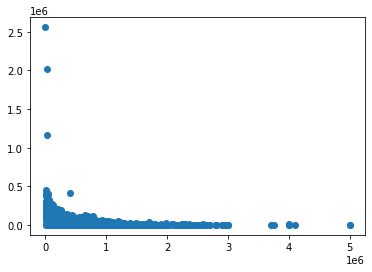

In [75]:
# sns.scatterplot(data=dados, x="company", y=preco, hue= dados['company'])

plt.scatter(dados['price_in_aed'],dados['kilometers'])
plt.show()

----
### Preço x Combustivo

In [77]:
pd.crosstab(dados['price_in_aed'], dados['fuel_type'])

fuel_type,Diesel,Electric,Gasoline,Hybrid
price_in_aed,,,,
6000.0,0,0,1,0
9900.0,0,0,1,0
11300.0,0,0,1,0
11500.0,0,0,2,0
11900.0,0,0,1,0
...,...,...,...,...
3750000.0,0,0,1,0
3999000.0,0,0,1,0
4000000.0,0,0,2,0
